In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, confusion_matrix, f1_score
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import xgboost as xgb

In [4]:
def get_rankings(item, df):
    
    # Empty dict for results
    item_count_dict = {}
    
    # For every tag in df
    for i in range(df.shape[1]):
        
        # Calculate % of cases that tagged the item
        val_counts = df.iloc[:,i].value_counts(normalize = True)
        if item in val_counts.index:
            item_counts = val_counts[item]
        else:
            item_counts = 0
        
        # Add score to dict
        item_count_dict["tag_{}".format(i)] = item_counts
    
    return item_count_dict

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

def list_as_cols(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict).dtype('int')

def get_genre_aggregations(df, genres, aggs, min_books=1):
    nr_books = [df[df[genre]==1].groupby(['reader_id'], as_index=False)[genre].sum() for genre in genres]
    
    agg_dfs = ([(df[df[genre]==1].groupby(['reader_id'], as_index=False)
                                 .agg(aggs)
                                 .set_index('reader_id')) for genre in genres])
    genre_agg_df = pd.concat(agg_dfs, axis=1)
    genre_agg_df.columns = genres
    return genre_agg_df

#### Import & Wrangle

In [199]:
readers = pd.read_csv('Data/readers.csv').drop_duplicates()
readers_books = pd.read_csv('Data/readers_books.csv')
books = pd.read_csv('Data/Books/all_books.csv')

In [57]:
#readers_books[readers_books.book_id==12914].shape ATTEMPT TO SCRAPE AGAIN

(11, 11)

In [60]:
books_genres = books.iloc[:,[1,10]]
#books_genres['genres'] = books_genres.genres.apply(eval)

In [61]:
unique_genres = to_1D(books.genres.apply(eval)).value_counts().drop('Audiobook').index
top_genres = unique_genres[:60].index
#genres_expanded_v1 = books_genres["genres"].apply(pd.Series)
#sns.barplot(y=genre_counts, x=genre_counts.index)

In [62]:
readers_books_genres = readers_books.merge(books_genres, on='book_id', how='inner')
my_genres = to_1D(readers_books_genres.genres.apply(eval)).value_counts().drop('Audiobook').index[:30]

In [100]:
#for genre_col in my_genres:
#    my_df[genre_col] = my_df['genres'].str.contains(genre_col).astype('int')

In [63]:
from sklearn.preprocessing import MultiLabelBinarizer

s = readers_books_genres['genres'].apply(eval)

mlb = MultiLabelBinarizer()

reader_genres = (pd.concat([
    readers_books_genres,
    pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=readers_books_genres.index)
    ], axis=1))

In [64]:
reader_genres['reader_bias'] = reader_genres.reader_rating-reader_genres.book_avg_rating
#reader_genres

#### Small test for bias performance

In [69]:
bias_test = get_genre_aggregations(reader_genres, ['Fiction','Young Adult','Fiction'],{'reader_bias':'mean'})
bias_test.head()

,Fiction,Young Adult,Fiction
reader_id,,,
4196,0.396538,0.530625,0.396538
13779,-0.559737,-1.346667,-0.559737
18029,-0.481818,-0.580426,-0.481818
21055,0.053333,0.043333,0.053333
23760,-1.145686,-0.882195,-1.145686


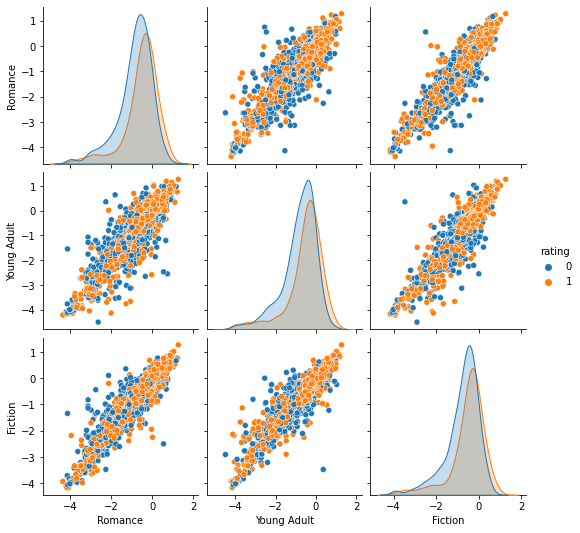

In [77]:
bias_test = pd.concat([readers.set_index('reader_id'),
                       get_genre_aggregations(reader_genres,
                                              ['Romance','Young Adult','Fiction'],
                                              {'reader_bias':'mean'})],
                      axis=1)
bias_test['rating'] = (bias_test.rating>=4).astype('int')
sns.pairplot(bias_test, hue='rating')

In [116]:
bias_test_lg = pd.concat([readers.set_index('reader_id'),
                       get_genre_aggregations(reader_genres,
                                              my_genres,
                                              {'reader_bias':'mean'})],
                      axis=1)
bias_test_lg['rating'] = (bias_test_lg.rating>=4).astype('int')

In [115]:
len(my_genres)

30

In [117]:
#XGBoost with all genres' biases (can handle missing values)
X_train, X_test, y_train, y_test = (train_test_split(bias_test_lg.iloc[:,1:],
                                                     bias_test_lg.rating,
                                                     test_size=0.1, random_state=1))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.115, random_state=2)

gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
gbm_fit = gbm.fit(X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='logloss', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [92]:
# Random Forest with just overall reader bias
avg_bias_test = (pd.concat([readers.set_index('reader_id'),
                           reader_genres.groupby('reader_id')['reader_bias'].mean()], axis=1).dropna())
avg_bias_test['rating'] = (avg_bias_test.rating<=4).astype('int')
X_tr_bias, X_te_bias, y_tr_bias, y_te_bias = (train_test_split(avg_bias_test[['reader_bias']], avg_bias_test.rating,
                                           test_size=.2, random_state=42))
rf_bias = RandomForestClassifier()
rf_bias.fit(X_tr_bias, y_tr_bias)

RandomForestClassifier()

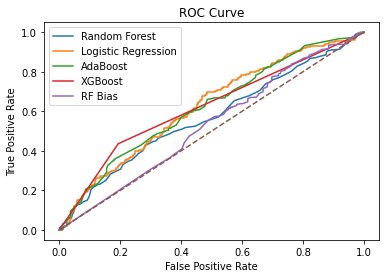

In [118]:
from sklearn.linear_model import LogisticRegression

X = bias_test.dropna().iloc[:,1:]
y = bias_test.dropna().rating
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.2, random_state=42)


rf = RandomForestClassifier()
rf.fit(X_tr, y_tr)

lr = LogisticRegression(C=100)
lr.fit(X_tr, y_tr)

ada = AdaBoostClassifier()
ada.fit(X_tr, y_tr)


fpr, tpr, _ = roc_curve(y_te, rf.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te, lr.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te, ada.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, gbm_fit.predict(X_test))
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te_bias, rf_bias.predict_proba(X_te_bias)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Random Forest', 'Logistic Regression', 'AdaBoost', 'XGBoost','RF Bias'])

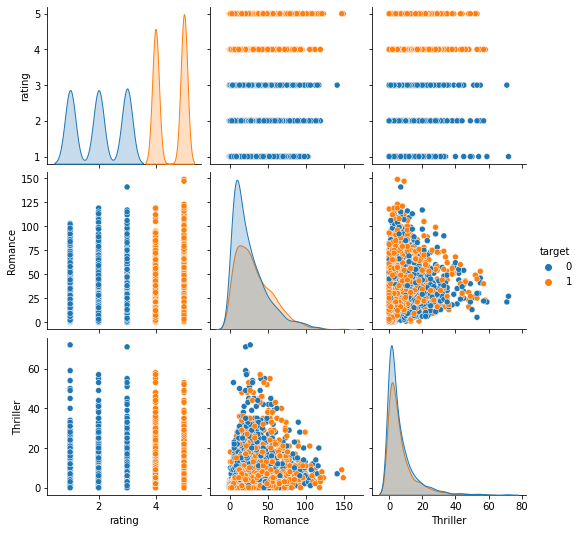

In [193]:
romance_nr = (pd.concat([readers.set_index('reader_id'),
                         reader_genres.groupby('reader_id')['Romance'].sum(),
                         reader_genres.groupby('reader_id')['Thriller'].sum()], axis=1)
              .dropna())
romance_nr['target'] = (romance_nr.rating>=4).astype('int')

sns.pairplot(romance_nr, hue='target')

In [81]:
confusion_matrix(y_test, gbm.predict(X_test))

array([[209,  55],
       [107,  65]])

In [82]:
f1_score(y_test, gbm.predict(X_test))

0.44520547945205474

#### Shap Tests

In [ ]:
import shap
from shap import TreeExplainer

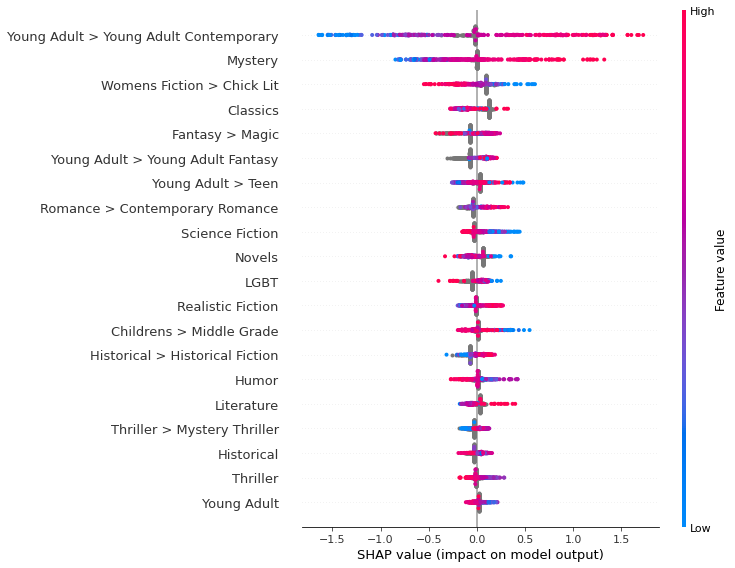

In [120]:
#XGBoost
exp = TreeExplainer(gbm_fit)
 
shap_vals = exp.shap_values(X_test)
shap_df = pd.DataFrame(shap_vals, columns=pd.Index(my_genres, name='genres'))
shap.summary_plot(shap_vals, X_test)

In [102]:
X_test.describe()

,Fiction,Young Adult,Romance,Contemporary,Fantasy,Adult,Adult Fiction,Mystery,Adventure,Historical > Historical Fiction,Realistic Fiction,Young Adult > Teen,Classics,Historical,Fantasy > Magic,Womens Fiction > Chick Lit,Novels,Science Fiction,Fantasy > Paranormal,Childrens
count,309.000000,307.000000,309.000000,308.000000,297.000000,296.000000,276.000000,298.000000,275.000000,287.000000,294.000000,283.000000,262.000000,282.000000,262.000000,259.000000,270.000000,275.000000,259.000000,251.000000
mean,-0.681160,-0.754715,-0.731542,-0.723485,-0.680467,-0.669432,-0.657101,-0.768860,-0.645599,-0.664925,-0.786600,-0.777729,-0.731724,-0.616359,-0.704734,-0.744580,-0.729032,-0.702577,-0.826097,-0.715635
std,0.865435,1.008232,0.924883,0.898265,0.958075,0.907542,0.925452,1.032253,1.076439,1.007217,1.017736,1.060519,1.123196,1.019666,1.168595,0.982090,0.970644,1.083856,1.168491,1.231465
min,-4.083448,-4.135000,-4.194444,-4.133846,-4.098947,-4.263333,-3.882000,-4.190000,-4.183333,-4.170000,-4.330000,-4.210000,-4.280000,-4.170000,-4.356471,-3.938704,-4.310000,-4.260000,-4.260000,-4.400000
25%,-0.927455,-1.102700,-1.111250,-1.039518,-0.993333,-0.989330,-1.042500,-1.135091,-0.987667,-0.943056,-1.133750,-1.226508,-1.195000,-1.029944,-1.176607,-1.173750,-1.160059,-1.153162,-1.386316,-1.092500
50%,-0.530661,-0.541250,-0.580294,-0.543090,-0.551698,-0.503917,-0.488611,-0.535937,-0.429375,-0.465357,-0.637222,-0.575000,-0.410182,-0.414561,-0.475000,-0.630000,-0.585000,-0.497778,-0.616389,-0.306667
75%,-0.121648,-0.107026,-0.145889,-0.156085,-0.076667,-0.126100,-0.095643,-0.126739,0.037628,-0.033571,-0.106023,-0.068955,-0.028500,0.000000,0.062103,-0.055714,-0.099017,-0.032619,-0.034028,0.075537
max,0.870000,1.190000,0.932000,0.999000,1.120000,1.160000,1.180000,1.085000,1.350000,1.060000,1.035000,0.963750,1.110000,0.940000,1.150000,1.260000,1.560000,1.120000,1.380000,1.210000


In [99]:
{column : X_test[column].max()-X_test[column].min()for column in my_genres[:20]}

{'Fiction': 4.953448275862069,
 'Young Adult': 5.324999999999999,
 'Romance': 5.126444444444445,
 'Contemporary': 5.132846153846153,
 'Fantasy': 5.218947368421053,
 'Adult': 5.423333333333333,
 'Adult Fiction': 5.062,
 'Mystery': 5.2749999999999995,
 'Adventure': 5.533333333333333,
 'Historical > Historical Fiction': 5.23,
 'Realistic Fiction': 5.365,
 'Young Adult > Teen': 5.17375,
 'Classics': 5.389999999999999,
 'Historical': 5.11,
 'Fantasy > Magic': 5.506470588235294,
 'Womens Fiction > Chick Lit': 5.198703703703703,
 'Novels': 5.869999999999999,
 'Science Fiction': 5.38,
 'Fantasy > Paranormal': 5.64,
 'Childrens': 5.61}

In [ ]:
#Random Forest

In [ ]:
exp = TreeExplainer(rf)

shap_vals = exp.shap_values(X_test)
shap_df = pd.DataFrame(shap_vals, columns=pd.Index(my_genres[:20], name='genres'))
shap.summary_plot(shap_vals, X_test)

#### Correlation Matrix

In [121]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [142]:
genres_matrix = boolean_df(books.genres, unique_genres[:50]).astype('int')
genres_freq_mat = np.dot(genres_matrix.T, genres_matrix)

In [146]:
genres_corr.iloc[:50,:50]

,Fiction,Young Adult,Romance,Contemporary,Adult,Fantasy,Mystery,Adult Fiction,Historical > Historical Fiction,Realistic Fiction,...,Fantasy > High Fantasy,Science Fiction Fantasy,Autobiography > Memoir,Biography,Young Adult > Coming Of Age,Book Club,Childrens > Juvenile,Academic > School,Health > Mental Health,Romance > Paranormal Romance
Fiction,1.000000,0.248182,0.206142,0.208577,0.317131,0.192256,0.111780,0.167158,0.156301,0.145247,...,0.078840,0.079567,-0.693486,-0.700299,0.069359,-0.015293,0.058895,0.016650,-0.092718,-0.059250
Young Adult,0.248182,1.000000,0.233997,-0.037998,0.417386,0.319613,-0.144451,-0.411391,-0.101267,0.335522,...,0.180915,0.011393,-0.230259,-0.221359,0.236172,-0.194606,0.139160,0.009442,0.017530,0.056608
Romance,0.206142,0.233997,1.000000,0.195293,0.272948,0.065081,-0.207089,0.035199,-0.063573,0.104874,...,0.090792,-0.157039,-0.214450,-0.216481,0.004975,-0.110079,-0.206570,-0.170103,0.010042,0.224469
Contemporary,0.208577,-0.037998,0.195293,1.000000,0.255326,-0.515098,0.093746,0.372208,-0.210903,0.405768,...,-0.215369,-0.199063,-0.170026,-0.175360,0.202519,0.081787,-0.107921,-0.097186,0.160245,-0.172366
Adult,0.317131,0.417386,0.272948,0.255326,1.000000,0.096137,0.021526,0.212284,-0.053555,0.135762,...,0.094673,-0.000052,-0.272652,-0.280121,0.098575,0.036917,-0.032834,-0.165404,0.006096,0.032010
Fantasy,0.192256,0.319613,0.065081,-0.515098,0.096137,1.000000,-0.077373,-0.311878,-0.087710,-0.321241,...,0.312384,0.305060,-0.192897,-0.194581,-0.169476,-0.165146,0.034873,-0.087050,-0.140248,0.260760
Mystery,0.111780,-0.144451,-0.207089,0.093746,0.021526,-0.077373,1.000000,0.057291,-0.016574,-0.086588,...,-0.091376,-0.066218,-0.097978,-0.089671,-0.059733,-0.011465,-0.031147,-0.079235,-0.078299,-0.038219
Adult Fiction,0.167158,-0.411391,0.035199,0.372208,0.212284,-0.311878,0.057291,1.000000,0.077584,-0.116660,...,-0.127477,-0.098978,-0.123624,-0.122745,-0.013111,0.334659,-0.118560,-0.101764,-0.015299,-0.090582
Historical > Historical Fiction,0.156301,-0.101267,-0.063573,-0.210903,-0.053555,-0.087710,-0.016574,0.077584,1.000000,-0.128945,...,-0.081169,-0.081655,-0.115595,-0.116604,0.024359,0.192260,-0.001972,0.074155,-0.095792,-0.097144
Realistic Fiction,0.145247,0.335522,0.104874,0.405768,0.135762,-0.321241,-0.086588,-0.116660,-0.128945,1.000000,...,-0.110767,-0.108170,-0.090163,-0.097655,0.317443,-0.057628,0.152250,0.063871,0.166257,-0.092462


In [143]:
genres_freq = pd.DataFrame(genres_freq_mat, columns = unique_genres[:50], index = unique_genres[:50])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'Fantasy > Urban Fantasy'),
  Text(1.5, 0, 'New Adult'),
  Text(2.5, 0, 'Science Fiction > Dystopia'),
  Text(3.5, 0, 'Family'),
  Text(4.5, 0, 'Suspense'),
  Text(5.5, 0, 'Literature'),
  Text(6.5, 0, 'Young Adult > Young Adult Contemporary'),
  Text(7.5, 0, 'Horror'),
  Text(8.5, 0, 'LGBT > Queer'),
  Text(9.5, 0, 'Fantasy > Supernatural')])

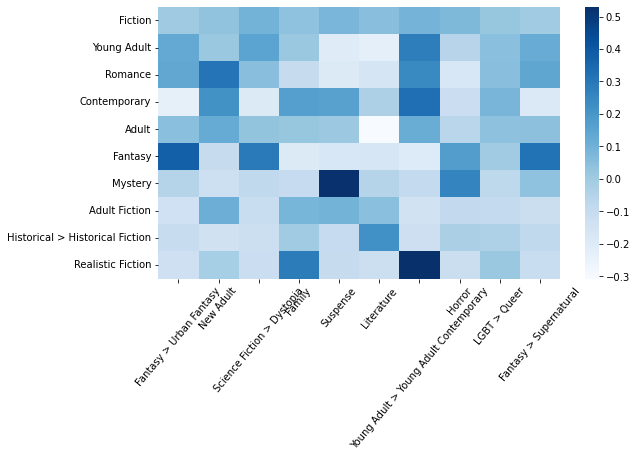

In [155]:
genres_corr = genres_matrix.corr(method = "pearson")
fig, ax = plt.subplots(figsize = (9,5))
sns.heatmap(genres_corr.iloc[:10,30:40], cmap = "Blues")
plt.xticks(rotation=50)

#### See rating within book distribution

In [302]:
books_stars.head()

,book_id,rating_distribution,1 Star,2 Stars,3 Stars,4 Stars,5 Stars,median_rating
0,45023611,"{'5 Stars': 8454, '4 Stars': 16217, '3 Stars':...",824,3067,12083,16217,8454,4
1,13662,"{'5 Stars': 38599, '4 Stars': 39593, '3 Stars'...",1302,3514,18726,39593,38599,4
2,1087204,"{'5 Stars': 97788, '4 Stars': 35181, '3 Stars'...",3545,4863,17782,35181,97788,5
3,17165932,"{'5 Stars': 11458, '4 Stars': 14506, '3 Stars'...",322,1695,8220,14506,11458,4
4,52397,"{'5 Stars': 44869, '4 Stars': 38190, '3 Stars'...",1535,3458,14729,38190,44869,4


In [297]:
def get_dist_rank(x):
    star = x['reader_rating']-1
    return ( (x[stars[star]]/2) + x[stars[:star]].sum() ) / x[stars].sum()

def get_likelihood(x):
    star = x['reader_rating']-1
    return x[stars[star]] / x[stars].sum()

def get_median(x):
    median = x[stars].sum()/2
    for star in range(1,6):
        if median <= x[stars[:int(star)]].sum():
            return star

In [279]:
reader = readers_books_dist[readers_books_dist.reader_rating==1].iloc[0]

In [243]:
books_stars = books.iloc[:,[1,-1]]
books_stars["rating_distribution"] = books_stars["rating_distribution"].apply(eval)
stars = ['1 Star','2 Stars','3 Stars','4 Stars','5 Stars']
for star in stars:
    books_stars[star] = books_stars.loc[:,'rating_distribution'].apply(lambda x: x[star])
books_stars['median_rating'] = books_stars.apply(get_median, axis=1)

In [264]:
readers_books_dist.head()

,reader_id,reader_rating,book_id,1 Star,2 Stars,3 Stars,4 Stars,5 Stars
0,2250020,4,45023611,824,3067,12083,16217,8454
1,30248594,4,45023611,824,3067,12083,16217,8454
2,4863162,3,45023611,824,3067,12083,16217,8454
3,5873788,2,45023611,824,3067,12083,16217,8454
4,584261,4,45023611,824,3067,12083,16217,8454


In [271]:
readers_books_dist = (readers_books.loc[:,['reader_id','reader_rating','book_id']]
                      .merge(books_stars.drop(columns=['rating_distribution']), on='book_id', how='right'))
readers_books_dist['distr_percentile'] = readers_books_dist.apply(get_dist_rank, axis=1)
readers_books_dist['rating_likelihood'] = readers_books_dist.apply(get_likelihood, axis=1)
readers_books_dist['bias_median'] = readers_books_dist.reader_rating - readers_books_dist.median_rating

#### Quantify Bias

In [ ]:
score = ({'doesnt read':0, 'reads little rates low':1, 'reads little rates high':2,
          'reads a lot rates low':3, 'reads a lot rates high':4}

#### My convoluted approach

In [63]:
def get_all_genres(string):
    all_genres = set()
    genres =  re.findall(r'\'(.*?)\'', string)
    for genre in genres:
        all_genres.add(genre)
    return all_genres

In [61]:
for genre_col in all_genres:
    books_genres[genre_col] = books_genres['genres'].str.contains("'" + genre_col + "'").astype('int')

/var/folders/tv/8qzgqvq554vgrs4zb6bwbwlm0000gn/T/ipykernel_20550/556243298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_genres[genre_col] = books_genres['genres'].str.contains("'" + genre_col + "'").astype('int')
/var/folders/tv/8qzgqvq554vgrs4zb6bwbwlm0000gn/T/ipykernel_20550/556243298.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  books_genres[genre_col] = books_genres['genres'].str.contains("'" + genre_col + "'").astype('int')


In [64]:
books_genres.columns[2:]

Index(['Christian Fiction', 'Historical > Victorian', 'Fantasy > Supernatural',
       'Literature > Asian Literature', 'Fantasy > Paranormal',
       'Biography Memoir', 'Inspirational', 'Cultural > India', 'Travel',
       'Book Club',
       ...
       'Gender', 'Sequential Art > Graphic Novels', 'Folklore > Monsters',
       'Dark', 'Historical Fiction > Historical Fantasy', 'Nonfiction',
       'Historical', 'Romance > Erotic Romance', 'World War II > Holocaust',
       'Mystery > Cozy Mystery'],
      dtype='object', length=248)

In [28]:
import re

In [57]:
type(books_genres.iloc[0,1])

str

In [53]:
type(books_genres.iloc[50,1])

str